In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from post_processing import *
from utils_mini import *

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_pickle('../features/train_v2.pkl')
# df_test= pd.read_pickle('../features/test_v2.pkl')
# sub = pd.read_csv("../input/sample_submission.csv")
# sub['time'] = [format(sub.time.values[x], '.4f') for x in range(2000000)]
TARGET = "open_channels"

# print(df_train.shape, df_test.shape, sub.shape)
df_train.head()

,time,signal,open_channels,local_time,batch,mini_batch
0,0.0001,-2.7600,0,0.0001,1.0,1.0
1,0.0002,-2.8557,0,0.0002,1.0,1.0
2,0.0003,-2.4074,0,0.0003,1.0,1.0
3,0.0004,-3.1404,0,0.0004,1.0,1.0
4,0.0005,-3.1525,0,0.0005,1.0,1.0


In [3]:
BATCH_GROUP = [5,10]
df_train = df_train[df_train.batch.isin(BATCH_GROUP)]

In [4]:
def fe(df):
    
    for shift_val in range(1, 6):
    
        df[f'shift+{shift_val}'] = df.groupby(['batch']).shift(shift_val)['signal']
        df[f'shift-{shift_val}'] = df.groupby(['batch']).shift(-shift_val)['signal']
        df[f'diff+{shift_val}'] = df[f'shift+{shift_val}'] - df['signal']
        df[f'diff-{shift_val}'] = df[f'shift-{shift_val}'] - df['signal']
    
    return df

print("feature engineering on training data ...")
df_train = fe(df_train)
# print("feature engineering on testing data ...")
# df_test = fe(df_test)
# print("feature engineering is done ...")

df_train.dropna(inplace=True)

feature engineering on training data ...


In [5]:
color_list = [
    "b", "g", "r", "c", "m", "k", "y", '#0000FF', '#8A2BE2', '#A52A2A',
    '#DEB887', '#5F9EA0'
]

# drop useless features
drop_features = [
    "time",
    "open_channels",
    "local_time",
    "batch",
    "mini_batch",
    "oof",
]
all_features = [col for col in df_train.columns if col not in drop_features]

# print("train/test shape is:", df_train.shape, df_test.shape)
print("features used # is", len(all_features))
df_train[all_features].head()

features used # is 21


,signal,shift+1,shift-1,diff+1,diff-1,shift+2,shift-2,diff+2,diff-2,shift+3,...,diff+3,diff-3,shift+4,shift-4,diff+4,diff-4,shift+5,shift-5,diff+5,diff-5
2000005,10.3870,10.1454,9.2749,-0.2416,-1.1121,10.0801,8.8249,-0.3069,-1.5621,9.6538,...,-0.7332,-1.0201,9.4972,9.4843,-0.8898,-0.9027,9.8451,9.5795,-0.5419,-0.8075
2000006,9.2749,10.3870,8.8249,1.1121,-0.4500,10.1454,9.3669,0.8705,0.0920,10.0801,...,0.8052,0.2094,9.6538,9.5795,0.3789,0.3046,9.4972,10.5734,0.2223,1.2985
2000007,8.8249,9.2749,9.3669,0.4500,0.5420,10.3870,9.4843,1.5621,0.6594,10.1454,...,1.3205,0.7546,10.0801,10.5734,1.2552,1.7485,9.6538,10.1389,0.8289,1.3140
2000008,9.3669,8.8249,9.4843,-0.5420,0.1174,9.2749,9.5795,-0.0920,0.2126,10.3870,...,1.0201,1.2065,10.1454,10.1389,0.7785,0.7720,10.0801,10.0907,0.7132,0.7238
2000009,9.4843,9.3669,9.5795,-0.1174,0.0952,8.8249,10.5734,-0.6594,1.0891,9.2749,...,-0.2094,0.6546,10.3870,10.0907,0.9027,0.6064,10.1454,9.8509,0.6611,0.3666


array([10,  9,  8,  7,  6,  5,  4,  3,  2])

Traning on folder 0 ...
[0]	validation_0-rmse:6.10645	validation_1-rmse:6.10646
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.280524	validation_1-rmse:0.287423
Stopping. Best iteration:
[95]	validation_0-rmse:0.283724	validation_1-rmse:0.28731

--- Vilid F1 score is 0.8685

Traning on folder 1 ...
[0]	validation_0-rmse:6.10644	validation_1-rmse:6.10639
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
[200]	validation_0-rmse:0.279708	validation_1-rmse:0.288584
Stopping. Best iteration:
[90]	validation_0-rmse:0.283273	validation_1-rmse:0.288488

--- Vilid F1 score is 0.8718

Traning on folder 2 ...
[0]	validation_0-rmse:6.10645	validation_1-rmse:6.10651
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stoppi

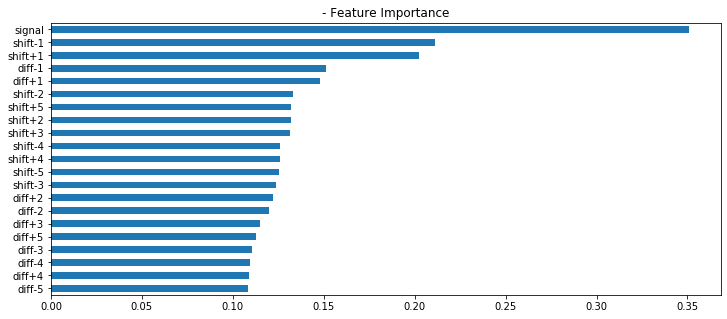

In [25]:
param = {
    "objective": "reg:squarederror",
    'metric': 'rmse',
    'num_leaves': 128,
    'learning_rate': 0.1,
    'n_estimators': 5000,
    'subsample': 1,
    "feature_fraction": 1,
    "lambda_l1": 0,
    "lambda_l2": 0,
    "max_depth": 7,
    "min_child_weight": 1,
    "min_split_gain": 0.001,
    'seed': 42,
    'n_jobs': -1,
    'tree_method':'gpu_hist',
    'importance_type':'weight',
}

cv= 3
kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=421)

oof_pred = np.zeros(df_train.shape[0])
# y_pred = np.zeros(df_test.shape[0])
# df_test[TARGET] = 0
fi_df = pd.DataFrame(index=all_features)

for fold, (train_index, valid_index) in enumerate(kf.split(df_train, y = df_train[TARGET])):

    print("Traning on folder", fold, "...")
    X_train, X_valid = df_train.iloc[train_index][all_features], df_train.iloc[valid_index][all_features]
    y_train, y_valid = df_train.iloc[train_index][TARGET], df_train.iloc[valid_index][TARGET]

    model_lgb = xgb.XGBRegressor(**param)

    model_lgb.fit(X_train, y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    early_stopping_rounds=200,
                    verbose=200)
    fi_df[f'importance_folder_{fold}'] = model_lgb.feature_importances_
    y_pred_valid = model_lgb.predict(X_valid)
    oof_pred[valid_index] = y_pred_valid

#     df_test[TARGET] += model_lgb.predict(df_test[all_features], num_iteration=model_lgb.best_iteration_) / cv
    print("--- Vilid F1 score is", f1_score(df_train.iloc[valid_index][TARGET], y_pred_valid.round().astype(int), average='macro').round(4))
    print("")

# optimize the round prediction
df_train.loc[df_train.batch.isin(BATCH_GROUP), "oof"] = oof_pred
optRf = OptimizedRounderF1_model5()
optRf.fit(df_train.loc[df_train.batch.isin(BATCH_GROUP), "oof"], df_train.loc[df_train.batch.isin(BATCH_GROUP), TARGET])
coefficientsf = optRf.coefficients()
print(coefficientsf)
df_train.loc[df_train.batch.isin(BATCH_GROUP), "oof"] = optRf.predict(df_train.loc[df_train.batch.isin(BATCH_GROUP), "oof"], coefficientsf)

# df_train["oof"] = oof_pred.round().astype(int)
# df_test[TARGET] = df_test[TARGET].round().astype(int)

# df_train = post_process_train(df_train)
# df_test = post_process_test(df_test)
print("-------------------------------------")

print("Overall F1 score is", f1_score(df_train[TARGET], df_train["oof"] , average='macro').round(4))

fi_df['importance'] = fi_df.sum(axis=1)
fi_df.sort_values('importance')['importance'][:30].plot(
    kind='barh',
    figsize=(12, 5),
    title='- Feature Importance',
)
plt.show()

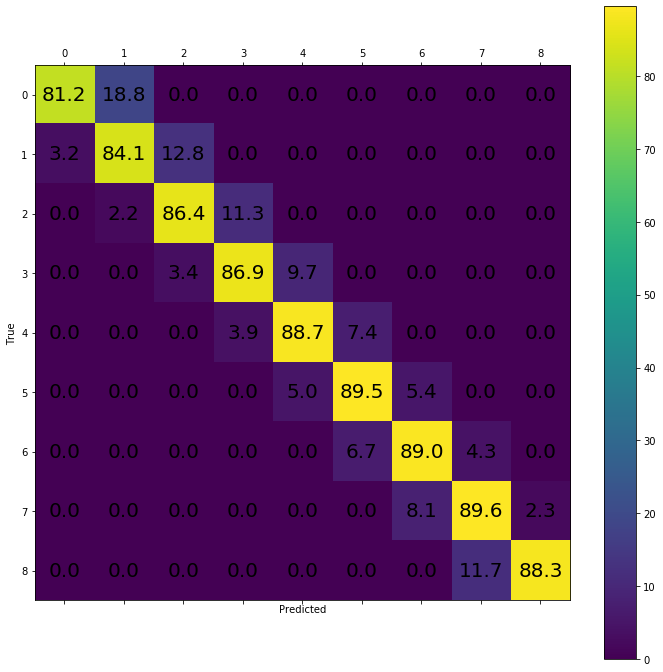

In [26]:
# confusion matrix
class_num = 9
cm = confusion_matrix(
    df_train.loc[df_train.batch.isin(BATCH_GROUP), TARGET] - 2,
    df_train.loc[df_train.batch.isin(BATCH_GROUP), "oof"].astype(int) - 2,
    range(class_num))
cm = cm / cm.sum(axis=1).reshape([-1,1]) * 100
labels = range(class_num)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=20)

fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

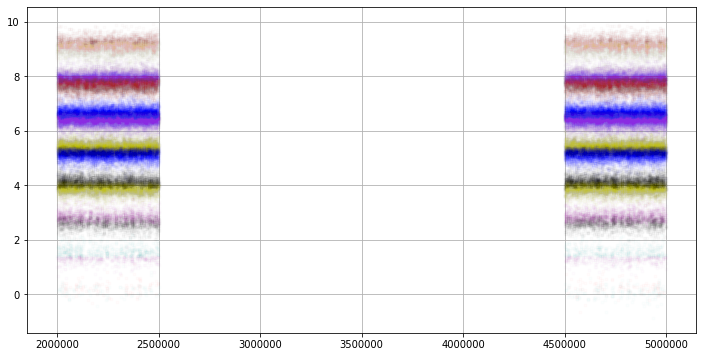

In [8]:
# oof error plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train[df_train.open_channels == channel_i][df_train.oof != df_train.open_channels].signal, ".", color=color_list[channel_i], alpha=0.01)